# Imports

In [323]:
import re
import numpy as np
import scipy
import pandas as pd
from tqdm import tqdm
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor
from transliterate import translit
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

## Download data

In [223]:
df1 = pd.read_csv('EEAPT_IS_Monthly_20170430.csv')
df2 = pd.read_csv('EEAPT_IS_Monthly_20170531.csv')
df3 = pd.read_csv('EEAPT_IS_Monthly_20170630.csv')
df4 = pd.read_csv('EEAPT_IS_Monthly_20170831.csv')

/usr/local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [326]:
d = pd.read_csv('EEAPT_IS_Monthly_20170531.csv')
d.head()

/usr/local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,1792,IE,N,20170525,DAY,20170525.1,10000000250001,81618705,643,Unnamed: 9,...,13,2001362183.1,Unnamed: 24,Unnamed: 25,Unnamed: 26,CS,1124.72,Unnamed: 29,.200,1183.04
0,1792,IE,N,20170525,DAY,20170525.0,10000000250001,81618706.0,643.0,NaN,...,13.0,2.001362e+09,NaN,NaN,NaN,CS,1012.24,NaN,0.100,1064.74
1,1792,IE,N,20170525,DAY,20170525.0,10000000250001,81631554.0,643.0,NaN,...,13.0,2.001362e+09,NaN,NaN,NaN,CS,234.26,NaN,0.333,246.40
2,1792,IE,N,20170525,DAY,20170525.0,10000000250001,81631556.0,643.0,NaN,...,13.0,2.001362e+09,NaN,NaN,NaN,CS,421.66,NaN,0.333,443.52
3,1792,IE,N,20170525,DAY,20170525.0,10000000250001,81632288.0,643.0,NaN,...,13.0,2.001362e+09,NaN,NaN,NaN,CS,448.85,NaN,0.208,472.15
4,1792,IE,N,20170525,DAY,20170525.0,10000000250001,81237865.0,643.0,NaN,...,13.0,2.001362e+09,NaN,NaN,NaN,CS,705.60,NaN,0.375,742.20


Look at date and item_id
Also look at numbers of different days and items

In [226]:
df1 = df1.iloc[:-2, [3,7]]
df1 = df1.assign(e=pd.Series(np.ones(len(df1.iloc[:, 0]))).values)
df1 = df1.assign(date=df1.iloc[:, 0])
df1 = df1.assign(id=df1.iloc[:, 1])
df1 = df1.iloc[:, 2:]
df1.head()

,e,date,id
0,1.0,20170409,81419613.0
1,1.0,20170409,81419612.0
2,1.0,20170409,81471253.0
3,1.0,20170409,81606637.0
4,1.0,20170409,81574314.0


In [225]:
df2 = df2.iloc[:-2, [3,7]]
df2 = df2.assign(e=pd.Series(np.ones(len(df2.iloc[:, 0]))).values)
df2 = df2.assign(date=df2.iloc[:, 0])
df2 = df2.assign(id=df2.iloc[:, 1])
df2 = df2.iloc[:, 2:]
df2.head()

,e,date,id
0,1.0,20170525,81618706.0
1,1.0,20170525,81631554.0
2,1.0,20170525,81631556.0
3,1.0,20170525,81632288.0
4,1.0,20170525,81237865.0


In [227]:
df3 = df3.iloc[:-2, [3,7]]
df3 = df3.assign(e=pd.Series(np.ones(len(df3.iloc[:, 0]))).values)
df3 = df3.assign(date=df3.iloc[:, 0])
df3 = df3.assign(id=df3.iloc[:, 1])
df3 = df3.iloc[:, 2:]
df3.head()

,e,date,id
0,1.0,20170607,81419607.0
1,1.0,20170607,81419607.0
2,1.0,20170607,81419607.0
3,1.0,20170607,81419607.0
4,1.0,20170607,81419607.0


In [228]:
df4 = df4.iloc[:-2, [3,7]]
df4 = df4.assign(e=pd.Series(np.ones(len(df4.iloc[:, 0]))).values)
df4 = df4.assign(date=df4.iloc[:, 0])
df4 = df4.assign(id=df4.iloc[:, 1])
df4 = df4.iloc[:, 2:]
df4.head()

,e,date,id
0,1.0,20170806,81419607.0
1,1.0,20170806,81419607.0
2,1.0,20170806,81419607.0
3,1.0,20170806,81419607.0
4,1.0,20170806,81419607.0


Concatenate all data

In [229]:
frames = [df1, df2, df3, df4]
result = pd.concat(frames)

In [230]:
result.head()

,e,date,id
0,1.0,20170409,81419613.0
1,1.0,20170409,81419612.0
2,1.0,20170409,81471253.0
3,1.0,20170409,81606637.0
4,1.0,20170409,81574314.0


In [231]:
df1_data = np.unique(pd.to_numeric(result.iloc[:, 1]))
df1_data

array([20170401, 20170402, 20170403, 20170404, 20170405, 20170406,
       20170407, 20170409, 20170410, 20170411, 20170412, 20170413,
       20170414, 20170415, 20170416, 20170417, 20170418, 20170419,
       20170420, 20170421, 20170422, 20170423, 20170424, 20170425,
       20170426, 20170427, 20170428, 20170429, 20170430, 20170501,
       20170502, 20170503, 20170504, 20170505, 20170506, 20170507,
       20170508, 20170509, 20170510, 20170511, 20170512, 20170513,
       20170514, 20170515, 20170516, 20170517, 20170518, 20170519,
       20170520, 20170521, 20170522, 20170523, 20170524, 20170525,
       20170526, 20170527, 20170528, 20170529, 20170530, 20170531,
       20170601, 20170602, 20170604, 20170605, 20170606, 20170607,
       20170608, 20170609, 20170610, 20170611, 20170612, 20170613,
       20170614, 20170615, 20170616, 20170617, 20170618, 20170619,
       20170620, 20170621, 20170622, 20170623, 20170624, 20170625,
       20170626, 20170627, 20170628, 20170629, 20170630, 20170

In [232]:
df1_item = np.unique(pd.to_numeric(result.iloc[:, 2]))
len(df1_item)

2741

## Выведем данные о количестве покупок каждого товара

In [264]:
item1=result[result.iloc[:,2] == df1_item[100]].iloc[:,:2]
item1.head()

,e,date
865164,1.0,20170613


### Выберем товары, по которым у на много данных
по 3к товарам у нас нет достаточно данных

In [290]:
l = []
good_item = []
for i in range(len(df1_item)):
    l.append(len(result[result.iloc[:,2] == df1_item[i]].iloc[:,:2]))
    if len(result[result.iloc[:,2] == df1_item[i]].iloc[:,:2]) > 10000:
        good_item.append(i)
l = np.array(l)
l.sort()

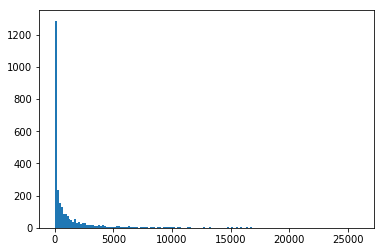

In [270]:
plt.hist(l, bins='auto')
plt.show()

In [288]:
len(good_item_15000)

21

In [291]:
len(good_item)

49

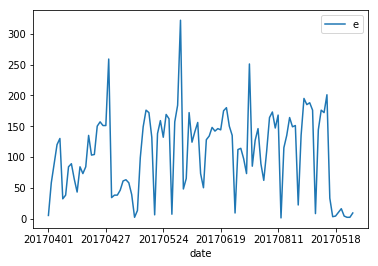

In [314]:
item1=result[result.iloc[:,2] == df1_item[2460]].iloc[:,:2]
item1.head()
table_df1 = item1.groupby(['date']).sum()
table_df1.plot()


# Все плохо -- данных мало
Попробуем объединить по подгруппам

In [305]:
product = pd.read_csv('Restricted_Product Master Data.csv', encoding = "1251", sep=';')
product

,Дата создания записи,Дата последнего изменения записи,Сектор (русское наименование),Сектор (английское наименование),Идентификатор сектора,Субсектор (русское наименование),Субсектор (английское наименование),Идентификатор субсектора,Категория (русское наименование),Категория (английское наименование),...,Краткое фактическое название бренда,"Список кодов заказчиков, которым товар может быть продан",Примерная дата конвертации старого продукта на новый для зоны 5,Примерная дата конвертации старого продукта на новый для зоны 6,Компоненты сложных продуктов,Единица измерения компонентов,Количество компонентов,Код УКТЗЭД,Примерная дата конвертации старого продукта на новый для зоны 7,Дата начала отгрузок для Белоруссии
0,31/07/2015,22/10/2017,Чистящие/ моющие средства/ средства ухода за д...,LCB,100001,Средства ухода за тканями,Fabric Care,200011,Синтетические моющие средства для стирки,Laundry,...,ARIEL,NaN,18/08/2015,NaN,NaN,NaN,NaN,3402209000,NaN,NaN
1,08/12/2016,22/10/2017,Чистящие/ моющие средства/ средства ухода за д...,LCB,100001,Средства ухода за тканями,Fabric Care,200011,Синтетические моющие средства для стирки,Laundry,...,ARIEL,NaN,NaN,NaN,NaN,NaN,NaN,3402209000,NaN,05/12/2016
2,20/05/2017,22/10/2017,Чистящие/ моющие средства/ средства ухода за д...,LCB,100001,Средства ухода за тканями,Fabric Care,200011,Синтетические моющие средства для стирки,Laundry,...,ARIEL,NaN,NaN,NaN,NaN,NaN,NaN,3402209000,NaN,15/01/2017
3,31/07/2015,22/10/2017,Чистящие/ моющие средства/ средства ухода за д...,LCB,100001,Средства ухода за тканями,Fabric Care,200011,Синтетические моющие средства для стирки,Laundry,...,ARIEL,NaN,11/08/2015,NaN,NaN,NaN,NaN,3402209000,NaN,NaN
4,08/12/2016,22/10/2017,Чистящие/ моющие средства/ средства ухода за д...,LCB,100001,Средства ухода за тканями,Fabric Care,200011,Синтетические моющие средства для стирки,Laundry,...,ARIEL,NaN,NaN,NaN,NaN,NaN,NaN,3402209000,NaN,05/12/2016
5,20/05/2017,22/10/2017,Чистящие/ моющие средства/ средства ухода за д...,LCB,100001,Средства ухода за тканями,Fabric Care,200011,Синтетические моющие средства для стирки,Laundry,...,ARIEL,NaN,NaN,NaN,NaN,NaN,NaN,3402209000,NaN,15/01/2017
6,30/10/2015,22/10/2017,Чистящие/ моющие средства/ средства ухода за д...,LCB,100001,Средства ухода за тканями,Fabric Care,200011,Синтетические моющие средства для стирки,Laundry,...,TIDE,NaN,NaN,NaN,NaN,NaN,NaN,3402209000,NaN,NaN
7,18/05/2017,22/10/2017,Чистящие/ моющие средства/ средства ухода за д...,LCB,100001,Средства ухода за тканями,Fabric Care,200011,Синтетические моющие средства для стирки,Laundry,...,TIDE,NaN,NaN,NaN,NaN,NaN,NaN,3402209000,NaN,01/06/2017
8,31/05/2017,22/10/2017,Чистящие/ моющие средства/ средства ухода за д...,LCB,100001,Средства ухода за тканями,Fabric Care,200011,Синтетические моющие средства для стирки,Laundry,...,TIDE,NaN,NaN,NaN,NaN,NaN,NaN,3402209000,NaN,01/04/2017
9,30/10/2015,22/10/2017,Чистящие/ моющие средства/ средства ухода за д...,LCB,100001,Средства ухода за тканями,Fabric Care,200011,Синтетические моющие средства для стирки,Laundry,...,TIDE,NaN,NaN,NaN,NaN,NaN,NaN,3402209000,NaN,NaN


## Не помогло
Сделаем разную для разных типов

### LSTM для больших данных

In [319]:
import matplotlib.pyplot as plt
import pandas
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [ ]:
# create and fit the LSTM network
item1=result[result.iloc[:,2] == df1_item[2460]].iloc[:,:2].groupby(['date']).sum()
model = Sequential()
model.add(LSTM(4, input_shape=(1, item1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

In [ ]:
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

### Средние данные
#### Линейная регрессия

In [ ]:
def ab(estimate, actual):
    return np.sum(abs(estimate - actual))*100/np.sum(actual)
def ds(estimate, actual):
    return 100/len(estimate)*np.sum(abs(estimate - actual)/actual)

In [ ]:
dataset_raw = item1=result[result.iloc[:,2] == df1_item[2460]].iloc[:,:2].groupby(['date']).sum()
data.loc[:,'month'] = [data['Promo start'][j].month for j in data.index]
data.drop(['Goods', 'Promo start', 'Promo end'], axis=1, inplace=True)
data.loc[:,'Discount'].replace(['-', ' - '], 0, inplace=True)

data_encoded = pd.get_dummies(data, columns=['Customer Material Number','Promo type', 'Group', 'Brand'])
train = data_encoded.iloc[:-40,:]
train = train[train['Orders'] > 100]
train = train[train['Orders'] < 10000]
train_data = train.drop('Orders', axis = 1)
train_labels = train['Orders'].values
test_data = data_encoded.iloc[-40:, :].drop('Orders', axis = 1)
test = data_encoded['Orders'].iloc[-40:]

scaler = StandardScaler()
X = scaler.fit_transform(train_data, train_labels)
Regressor = LinearRegression()
Regressor.fit(X, train_labels)
res = Regressor.predict(scaler.transform(test_data))
dataset_raw.loc[:,'Rishat_regression'] = ''
dataset_raw.iloc[-40:, dataset_raw.columns.get_loc('Rishat_regression')] = res.astype(int)
dataset_raw.to_excel("Output.xlsx")

#### Catboost

In [ ]:
dataset_raw = item1=result[result.iloc[:,2] == df1_item[2460]].iloc[:,:2].groupby(['date']).sum()
data.loc[:,'month'] = [data['Promo start'][j].month for j in data.index]
data.drop(['Goods', 'Promo start', 'Promo end'], axis=1, inplace=True)
data.loc[:,'Discount'].replace(['-', ' - '], 0, inplace=True)
for i in data.index:
    data.loc[i,'Promo type'] = translit(data['Promo type'][i],'ru', reversed=True )
    data.loc[i,'Customer Material Number'] = translit(data['Customer Material Number'][i],'ru', reversed=True )

train = data.iloc[:-40,:]
train = train[train['Orders'] > 100]
train = train[train['Orders'] < 100000]
train_data = train.drop('Orders', axis = 1)
train_labels = train['Orders'].values
test_data = data.iloc[-40:, :].drop('Orders', axis = 1)
test = data['Orders'].iloc[-40:]

cat_features = [0, 2, 3, 5]
model = CatBoostRegressor(iterations = 200, learning_rate=0.05, depth=4, loss_function='RMSE',one_hot_max_size=20, has_time =True, l2_leaf_reg=100)
model.fit(train_data, train_labels, cat_features)
res = model.predict(test_data)

dataset_raw.loc[:,'Rishat_model2'] = ''
dataset_raw.iloc[-40:, dataset_raw.columns.get_loc('Rishat_model2')] = res.astype(int)
dataset_raw.to_excel("Output.xlsx")

#### XGBoost

In [ ]:
# Read the stock data 
symbol = "ACC"
fileName = paste(getwd(),"/",symbol,".csv",sep="") ; 
df = as.data.frame(read.csv(fileName))
colnames(df) = c("Date","Time","Close","High", "Low", "Open","Volume")

# Define the technical indicators to build the model 
rsi = RSI(df$Close, n=14, maType="WMA")
adx = data.frame(ADX(df[,c("High","Low","Close")]))
sar = SAR(df[,c("High","Low")], accel = c(0.02, 0.2))
trend = df$Close - sar

# create a lag in the technical indicators to avoid look-ahead bias 
rsi = c(NA,head(rsi,-1)) 
adx$ADX = c(NA,head(adx$ADX,-1)) 
trend = c(NA,head(trend,-1))

# Split data into train and test sets 
train_size = 2/3
breakpoint = nrow(model) * train_size

training_data = model[1:breakpoint,]
test_data = model[(breakpoint+1):nrow(model),]

# Split data training and test data into X and Y
X_train = training_data[,2:4] ; Y_train = training_data[,1]
class(X_train)[1]; class(Y_train)

X_test = test_data[,2:4] ; Y_test = test_data[,1]
class(X_test)[1]; class(Y_test)
# Train the xgboost model using the "xgboost" function

dtrain = xgb.DMatrix(data = X_train, label = Y_train)
xgModel = xgboost(data = dtrain, nround = 5, objective = "binary:logistic")

### Маленькие данные
Просто будем их переодично выводить

# Take adress

In [25]:
cmd = pd.read_csv('Customers Master Data.csv')
cmd.head()

,SRCE_SYS_ID,FACT_TYPE_CODE,SBMSN_TYPE_CODE,DUE_PERD,TIME_PERD_TYPE_CODE,TIME_PERD_START_DATE,TRADE_CHANNEL_ID,CUST_ID,LGCY_STORE_ID,DIST_BRANCH_ID,...,GENERIC_TEXT_FIELD_1,GENERIC_TEXT_FIELD_2,GENERIC_TEXT_FIELD_3,STORE_TYPE,DISTR_CUST_NAME,DISTR_CUST_ID,GENERIC_NUM_FIELD_2,GENERIC_NUM_FIELD_3,GENERIC_NUM_FIELD_4,GENERIC_NUM_FIELD_5
0,1792,SX,N,20170930,MH,20170901.0,NaN,2.002487e+09,30000001650003,2.001362e+09,...,km001650,2.001362e+09,NaN,1.0,ШАМКИР ПЛЮС ООО,2.706028e+09,136.899166,50.218551,1.0,1.0
1,1792,SX,N,20170930,MH,20170901.0,NaN,2.002487e+09,km000002192,2.001362e+09,...,km001650,2.001362e+09,NaN,1.0,ШАМКИР ПЛЮС ООО,2.706028e+09,136.904974,50.228439,1.0,1.0
2,1792,SX,N,20170930,MH,20170901.0,NaN,2.002487e+09,km000001933,2.001362e+09,...,km001650,2.001362e+09,NaN,1.0,ШАМКИР ПЛЮС ООО,2.706028e+09,136.916483,50.245507,1.0,1.0
3,1792,SX,N,20170930,MH,20170901.0,NaN,2.002487e+09,km000001843,2.001362e+09,...,km001650,2.001362e+09,NaN,1.0,ШАМКИР ПЛЮС ООО,2.706028e+09,136.920871,50.247561,1.0,1.0
4,1792,SX,N,20170930,MH,20170901.0,NaN,2.002487e+09,km000002562,2.001362e+09,...,km001650,2.001362e+09,NaN,1.0,ШАМКИР ПЛЮС ООО,2.706028e+09,136.911918,50.238378,1.0,1.0


In [86]:
shop_adress = cmd.iloc[41,[14,15, 16,27]]
shop_adress.head()

STORE_NAME                 м-н Иваныч
STORE_ADDRESS_1        Октябрьская 15
STORE_ADDRESS_2            Корсаков г
GENERIC_NUM_FIELD_4                 1
Name: 41, dtype: object

## Geocoding

In [72]:
from geopy.geocoders import Nominatim
geolocator = Nominatim()
location = geolocator.geocode("Мира 43")
print(location.address)
print((location.latitude, location.longitude))

Мира 43, проспект Мира, городское поселение Нижнекамск, Нижнекамский район, Татарстан, Приволжский федеральный округ, 423570, РФ
(55.6495613, 51.8113208)


## Print Map

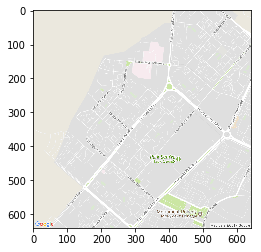

In [73]:
from io import BytesIO
from PIL import Image
from urllib import request
import matplotlib.pyplot as plt # this is if you want to plot the map using pyplot

url = "http://maps.googleapis.com/maps/api/staticmap?center=55.6495613,51.8113208&size=800x800&zoom=14&sensor=false"

buffer = BytesIO(request.urlopen(url).read())
image = Image.open(buffer)

# Show Using PIL
image.show()

# Or using pyplot
plt.imshow(image)
plt.show()

# Take different type of shop


In [87]:
cmd = pd.read_csv('Customers Master Data.csv')
cmd.head()
shop_adress = cmd.iloc[:,[14,15,16,22]]
type_1 = shop_adress[shop_adress.STORE_TYPE == 1]
type_1.head()

,STORE_NAME,STORE_ADDRESS_1,STORE_ADDRESS_2,STORE_TYPE
0,Шамкир ООО Амурск Пионерская д 15 корп б,Пионерская 15,Амурск г,1.0
1,Шамкир ООО Амурск г Победы пр-кт д 21,Победы пр-кт 21,Амурск г,1.0
2,Шамкир ООО Амурск г Строителей пр-кт д 56,Строителей пр-кт 56,Амурск г,1.0
3,Шамкир ООО Амурск г Строителей пр-кт д 72,Строителей пр-кт 72,Амурск г,1.0
4,Шамкир ООО Амурск г Строителей пр-кт д 32 ...,Строителей пр-кт 32,Амурск г,1.0


In [57]:
cmd = pd.read_csv('Customers Master Data.csv')
cmd.head()
shop_adress = cmd.iloc[:,[14,15,16,22]]
type_0 = shop_adress[shop_adress.STORE_TYPE == 0]
type_0

,STORE_NAME,STORE_ADDRESS_1,STORE_ADDRESS_2,STORE_TYPE
51,м-н Ч С Б,Мира 43,Шахтерск г,0.0
151,Прачечная Фея,Жорницкого 27,Якутск г,0.0
167,ГиперГанза Якутск,Покровское 7 км ш 1,Якутск г,0.0
174,м-н ДОМАШНИЙ,50 лет Октября пр-кт 7,Петропавловск-Камчатский г,0.0
192,Фрис И Н м-н Маяк,О.Кальвица 16,Чокурдах п,0.0
261,ПО Илгэ Вилюйск,Каландарашвили 23,Вилюйск г,0.0
370,м-н Нектар,Хабаровская 4,Долинск г,0.0
406,Ефимова Е А ИП Военный м-н,Центральная 1,Монгохто п,0.0
407,СОТРУДНИК,Пушкина 183,Благовещенск г,0.0
412,СОТРУДНИК,NaN,Комсомольск-на-Амуре г,0.0


In [88]:
cmd = pd.read_csv('Customers Master Data.csv')
cmd.head()
shop_adress = cmd.iloc[:,[14,15,16,22]]
type_2 = shop_adress[shop_adress.STORE_TYPE == 2]
type_2.head()

,STORE_NAME,STORE_ADDRESS_1,STORE_ADDRESS_2,STORE_TYPE
8,Клад ООО Амурск г Строителей пр-кт д 18 м-г...,Строителей пр-кт 18,Амурск г,2.0
11,Склад Санвей Производственный 12А,Производственная 12,Хабаровск г,2.0
18,п Горького ул Молодежная 21,Молодежная 21,Хабаровск г,2.0
19,пр-т 60-лет Октября 162 м-11а,60 лет Октября пр-кт 162,Хабаровск г,2.0
26,г Хаб пер Производственный д12 (ОПТ),Производственный пер 12,Хабаровск г,2.0
